In [2]:
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.tokenize import sent_tokenize, word_tokenize

from sklearn import decomposition, ensemble
import logging
import pandas as pd
import numpy as np
from numpy import random
#import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from nltk.stem import PorterStemmer
from sklearn.preprocessing import LabelEncoder
from nltk.stem import LancasterStemmer, WordNetLemmatizer
porter = PorterStemmer()

import warnings
warnings.filterwarnings('ignore')

import re
from bs4 import BeautifulSoup
%matplotlib inline



In [7]:
df = pd.read_csv('google-maps-single-dataset-for-conference.csv',encoding='ISO-8859-1')
df= df[pd.notnull(df['Claim_Type'])]
print(len(df))

df = df.replace("neu ", "neu")
df = df.replace("supporting ", "supporting")
df = df.replace("attacking ", "attacking")
df = df.replace("atacking ", "attacking")
df = df.replace("attacknig ", "attacking")
df= df[df.Rationale_Type=='claim']

#df = df.replace("alternative", "new feature")
print(df.Claim_Type.value_counts())
#print(df.head(10))
#print(df['comment_Text'].apply(lambda x: len(x.split(' '))).sum())

2077
neu           772
supporting    762
attacking     542
Name: Claim_Type, dtype: int64


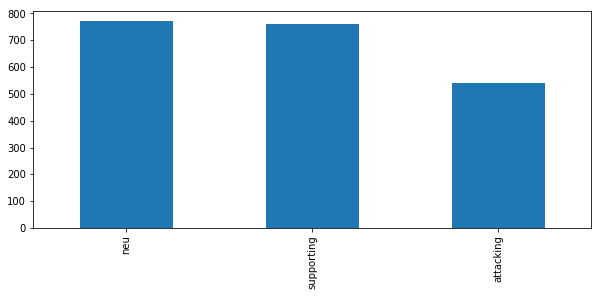

In [9]:
my_tags = ['claim-neu','claim-supporting','claim-attacking']
plt.figure(figsize=(10,4))
df.Claim_Type.value_counts().plot(kind='bar');

In [10]:
#vect = CountVectorizer(max_features=1000, binary=True)
#X= vect.fit_transform(df.comment_Text)
#X.toarray()

In [11]:
def print_plot(index):
    example = df[df.index == index][['comment_Text', 'Rationale_Type']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Rationale_Type:', example[1])

In [12]:
print_plot(61)

I've been waiting for this for so long. 

Trying to meet up with friends at a restaurant? Now you know if you should order drinks first or wait for everyone to arrive.

Looking for a friend's house in new construction area? Now you don't have to search street by street.

Why did something like this take Google this long to roll out?
Rationale_Type: claim


In [13]:
#df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\<\>\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z =#+_]')
#STOPWORDS = set(stopwords.words('english'))

def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_url(text):
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    return text

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = strip_html(text) 
    text = remove_url(text)
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    #text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    #text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df['comment_Text'] = df['comment_Text'].apply(clean_text)
#df['Consumer complaint narrative'] = df['Consumer complaint narrative'].str.replace('\d+', '')

In [14]:
print_plot(61)
#print (df['comment_Text'])


ive been waiting for this for so long trying to meet up with friends at a restaurant now you know if you should order drinks first or wait for everyone to arrivelooking for a friends house in new construction area now you dont have to search street by streetwhy did something like this take google this long to roll out
Rationale_Type: claim


In [15]:
#user_comments= df.comment_Text.values.astype('U')
#rationale_type= df.Rationale_Type.values.astype('U')

In [16]:
lemmatizer = WordNetLemmatizer()
def lemmaSentence(sentence):
    token_words=word_tokenize(sentence)
    token_words
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(lemmatizer.lemmatize(word, pos='v'))        
        stem_sentence.append(" ")
    return "".join(stem_sentence)




In [21]:
user_comments_stemmed = []
#print (df['comment_Text'].values)
for i in df['comment_Text']:
    #print (i)
    user_comments=lemmaSentence(i)
    user_comments_stemmed.append(user_comments)
#print(user_comments_stemmed)

    #allwords_stemmed = tokenize_and_stem(i) # for each item in 'synopses', tokenize/stem
    #totalvocab_stemmed.extend(allwords_stemmed) 
#print(totalvocab_stemmed)

In [22]:
#X = df.comment_Text.values.astype('U')
X = user_comments_stemmed
X = np.array(X)
#X = list(map(int, X))
y = df.Claim_Type.values.astype('U')


In [23]:
#added extra
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    #fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    #predictions the labels on validation dataset
    predictions= classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions= predictions.argmax(axis= -1)
        
    return predictions

In [24]:
#Kfold classification for NBM, SVM, LR and RF using countvectorizor

kf= KFold(n_splits=10)
#curr_fold= 0
alg_accurcy_NBM =[]
alg_accurcy_SVM =[]
alg_accurcy_LR =[]
alg_accurcy_RF =[]

score_array_NBM= []
score_array_SVM= []
score_array_LR= []
score_array_RF= []
for train_idx, test_idx in kf.split(X):
    X_train, X_test= X[train_idx], X[test_idx]
    y_train, y_test= y[train_idx], y[test_idx]
    vect= CountVectorizer(max_features=10000, binary=True)
    X_train_vect= vect.fit_transform(X_train)
    X_test_vect = vect.transform(X_test)
    encoder= LabelEncoder()
    Y_train_vect= encoder.fit_transform(y_train)
    Y_test_vect= encoder.fit_transform(y_test)
    
    sm= SMOTE()
    X_train_res, y_train_res= sm.fit_sample(X_train_vect, Y_train_vect)
    predictions = train_model(naive_bayes.MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),X_train_res,y_train_res,X_test_vect)
    alg_accurcy_NBM.append(accuracy_score(predictions, Y_test_vect))
    score_array_NBM.append(precision_recall_fscore_support(Y_test_vect,predictions, average=None))
    #print(classification_report(y_test, predictions,target_names=my_tags))
    
    predictions = train_model(svm.SVC(),X_train_res,y_train_res,X_test_vect)
    alg_accurcy_SVM.append(accuracy_score(predictions, Y_test_vect))
    score_array_SVM.append(precision_recall_fscore_support(Y_test_vect,predictions, average=None))
    #print(classification_report(y_test, predictions,target_names=my_tags))
    
    predictions = train_model(linear_model.LogisticRegression(),X_train_res,y_train_res,X_test_vect)
    alg_accurcy_LR.append(accuracy_score(predictions, Y_test_vect))
    score_array_LR.append(precision_recall_fscore_support(Y_test_vect,predictions, average=None))
    #print(classification_report(y_test, predictions,target_names=my_tags))
    
    predictions = train_model(ensemble.RandomForestClassifier(),X_train_res,y_train_res,X_test_vect)
    alg_accurcy_RF.append(accuracy_score(predictions, Y_test_vect))
    score_array_RF.append(precision_recall_fscore_support(Y_test_vect,predictions, average=None))
    #print(classification_report(y_test, predictions,target_names=my_tags))

average_accuracy_NBM= np.mean(alg_accurcy_NBM, axis=0)
print("the average accuracy of NBM is",average_accuracy_NBM)

average_accuracy_SVM= np.mean(alg_accurcy_SVM, axis=0)
print("the average accuracy of SVM is",average_accuracy_SVM)

average_accuracy_LR= np.mean(alg_accurcy_LR, axis=0)
print("the average accuracy of LR is",average_accuracy_LR)

average_accuracy_RF= np.mean(alg_accurcy_RF, axis=0)
print("the average accuracy of RF is",average_accuracy_RF)
    
average_scire_NBM=np.mean(score_array_NBM, axis=0)
print(average_scire_NBM)

average_scire_SVM=np.mean(score_array_SVM, axis=0)
print(average_scire_SVM)

average_scire_LR=np.mean(score_array_LR, axis=0)
print(average_scire_LR)

average_scire_RF=np.mean(score_array_RF, axis=0)
print(average_scire_RF)

the average accuracy of NBM is 0.44795150501672243
the average accuracy of SVM is 0.4052164622816797
the average accuracy of LR is 0.45476356373095506
the average accuracy of RF is 0.3959332032701598
[[ 0.34845567  0.59031029  0.48652028]
 [ 0.50609753  0.21835853  0.64926849]
 [ 0.40859593  0.31353572  0.54964797]
 [54.2        77.2        76.2       ]]
[[4.54242979e-01 4.00400297e-01 4.66850831e-01]
 [5.43545507e-02 9.34473256e-01 1.28618296e-01]
 [9.29493337e-02 5.53590602e-01 1.96201261e-01]
 [5.42000000e+01 7.72000000e+01 7.62000000e+01]]
[[ 0.31512352  0.49058491  0.53104572]
 [ 0.41082398  0.39197522  0.52977875]
 [ 0.35491039  0.43368279  0.52599669]
 [54.2        77.2        76.2       ]]
[[ 0.2972513   0.40576111  0.48501032]
 [ 0.46145002  0.28502103  0.43855191]
 [ 0.35912791  0.33229236  0.45795791]
 [54.2        77.2        76.2       ]]


In [25]:
#Kfold classification for NBM, SVM, LR and RF using TFIDF

kf= KFold(n_splits=10)
#curr_fold= 0
alg_accurcy_NBM_tfidf =[]
alg_accurcy_SVM_tfidf =[]
alg_accurcy_LR_tfidf =[]
alg_accurcy_RF_tfidf =[]



#x_train_tfidf

score_array_NBM_tfidf= []
score_array_SVM_tfidf= []
score_array_LR_tfidf= []
score_array_RF_tfidf= []
for train_idx, test_idx in kf.split(X):
    X_train, X_test= X[train_idx], X[test_idx]
    y_train, y_test= y[train_idx], y[test_idx]
    tfidf_vect= TfidfVectorizer(analyzer='word', token_pattern= r'\w{1,}', max_features=5000)
    tfidf_vect.fit(X_train)
    x_train_tfidf=tfidf_vect.transform(X_train)
    x_test_tfidf=tfidf_vect.transform(X_test)
    sm= SMOTE()
    X_train_res_tfidf, y_train_res_tfidf= sm.fit_sample(x_train_tfidf, y_train)
    predictions = train_model(naive_bayes.MultinomialNB(),X_train_res_tfidf,y_train_res_tfidf,x_test_tfidf)
    alg_accurcy_NBM_tfidf.append(accuracy_score(predictions, y_test))
    score_array_NBM_tfidf.append(precision_recall_fscore_support(y_test,predictions, average=None))
    #print(classification_report(y_test, predictions,target_names=my_tags))
    
    predictions = train_model(svm.SVC(),X_train_res_tfidf,y_train_res_tfidf,x_test_tfidf)
    alg_accurcy_SVM_tfidf.append(accuracy_score(predictions, y_test))
    score_array_SVM_tfidf.append(precision_recall_fscore_support(y_test,predictions, average=None))
    #print(classification_report(y_test, predictions,target_names=my_tags))
    
    predictions = train_model(linear_model.LogisticRegression(),X_train_res_tfidf,y_train_res_tfidf,x_test_tfidf)
    alg_accurcy_LR_tfidf.append(accuracy_score(predictions, y_test))
    score_array_LR_tfidf.append(precision_recall_fscore_support(y_test,predictions, average=None))
    #print(classification_report(y_test, predictions,target_names=my_tags))
    
    predictions = train_model(ensemble.RandomForestClassifier(),X_train_res_tfidf,y_train_res_tfidf,x_test_tfidf)
    alg_accurcy_RF_tfidf.append(accuracy_score(predictions, y_test))
    score_array_RF_tfidf.append(precision_recall_fscore_support(y_test,predictions, average=None))
    #print(classification_report(y_test, predictions,target_names=my_tags))

average_accuracy_NBM_tfidf= np.mean(alg_accurcy_NBM_tfidf, axis=0)
print("the average accuracy of NBM is",average_accuracy_NBM_tfidf)

average_accuracy_SVM_tfidf= np.mean(alg_accurcy_SVM_tfidf, axis=0)
print("the average accuracy of SVM is",average_accuracy_SVM_tfidf)

average_accuracy_LR_tfidf= np.mean(alg_accurcy_LR_tfidf, axis=0)
print("the average accuracy of LR is",average_accuracy_LR_tfidf)

average_accuracy_RF_tfidf= np.mean(alg_accurcy_RF_tfidf, axis=0)
print("the average accuracy of RF is",average_accuracy_RF_tfidf)
    
average_scire_NBM_tfidf=np.mean(score_array_NBM_tfidf, axis=0)
print(average_scire_NBM_tfidf)

average_scire_SVM_tfidf=np.mean(score_array_SVM_tfidf, axis=0)
print(average_scire_SVM_tfidf)

average_scire_LR_tfidf=np.mean(score_array_LR_tfidf, axis=0)
print(average_scire_LR_tfidf)

average_scire_RF_tfidf=np.mean(score_array_RF_tfidf, axis=0)
print(average_scire_RF_tfidf)

the average accuracy of NBM is 0.42625418060200665
the average accuracy of SVM is 0.44617242660720924
the average accuracy of LR is 0.5130388331475288
the average accuracy of RF is 0.4480629877369008
[[ 0.34148903  0.70050293  0.51402415]
 [ 0.7663425   0.12987431  0.48493578]
 [ 0.46830385  0.21529179  0.49295605]
 [54.2        77.2        76.2       ]]
[[ 0.36238987  0.46546337  0.66350679]
 [ 0.42813787  0.80896098  0.09973201]
 [ 0.38378158  0.58215743  0.17101148]
 [54.2        77.2        76.2       ]]
[[ 0.40842129  0.55044935  0.56123081]
 [ 0.45927155  0.5560345   0.5132132 ]
 [ 0.4258467   0.54455194  0.53017581]
 [54.2        77.2        76.2       ]]
[[ 0.36164508  0.48324438  0.47461356]
 [ 0.34528535  0.57923033  0.39830961]
 [ 0.34729041  0.51734864  0.42678841]
 [54.2        77.2        76.2       ]]


In [26]:
#Kfold classification for NBM, SVM, LR and RF using TFIDF-ngram with analizer= 'word' and ngram=1-3

kf= KFold(n_splits=10)
#curr_fold= 0
alg_accurcy_NBM_tfidf_W_ngram =[]
alg_accurcy_SVM_tfidf_W_ngram =[]
alg_accurcy_LR_tfidf_W_ngram =[]
alg_accurcy_RF_tfidf_W_ngram =[]



#x_train_tfidf

score_array_NBM_tfidf_W_ngram= []
score_array_SVM_tfidf_W_ngram= []
score_array_LR_tfidf_W_ngram= []
score_array_RF_tfidf_W_ngram= []
for train_idx, test_idx in kf.split(X):
    X_train, X_test= X[train_idx], X[test_idx]
    y_train, y_test= y[train_idx], y[test_idx]
    
    tfidf_vect_ngram= TfidfVectorizer(analyzer='word', token_pattern= r'\w{1,}', ngram_range=(1,3), max_features=5000)
    tfidf_vect_ngram.fit(X_train)
    x_train_ngram=tfidf_vect_ngram.transform(X_train)
    x_test_ngram=tfidf_vect_ngram.transform(X_test)
    
    sm= SMOTE()
    X_train_res_tfidf_ngram, y_train_res_tfidf_ngram= sm.fit_sample(x_train_ngram, y_train)

    
    predictions = train_model(naive_bayes.MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),X_train_res_tfidf_ngram,y_train_res_tfidf_ngram,x_test_ngram)
    alg_accurcy_NBM_tfidf_W_ngram.append(accuracy_score(predictions, y_test))
    score_array_NBM_tfidf_W_ngram.append(precision_recall_fscore_support(y_test,predictions, average=None))
    
    predictions = train_model(svm.SVC(),X_train_res_tfidf_ngram,y_train_res_tfidf_ngram,x_test_ngram)
    alg_accurcy_SVM_tfidf_W_ngram.append(accuracy_score(predictions, y_test))
    score_array_SVM_tfidf_W_ngram.append(precision_recall_fscore_support(y_test,predictions, average=None))
    
    predictions = train_model(linear_model.LogisticRegression(),X_train_res_tfidf_ngram,y_train_res_tfidf_ngram,x_test_ngram)
    alg_accurcy_LR_tfidf_W_ngram.append(accuracy_score(predictions, y_test))
    score_array_LR_tfidf_W_ngram.append(precision_recall_fscore_support(y_test,predictions, average=None))
    
    predictions = train_model(ensemble.RandomForestClassifier(),X_train_res_tfidf_ngram,y_train_res_tfidf_ngram,x_test_ngram)
    alg_accurcy_RF_tfidf_W_ngram.append(accuracy_score(predictions, y_test))
    score_array_RF_tfidf_W_ngram.append(precision_recall_fscore_support(y_test,predictions, average=None))

average_accuracy_NBM_tfidf_W_ngram= np.mean(alg_accurcy_NBM_tfidf_W_ngram, axis=0)
print("the average accuracy of NBM is",average_accuracy_NBM_tfidf_W_ngram)

average_accuracy_SVM_tfidf_W_ngram= np.mean(alg_accurcy_SVM_tfidf_W_ngram, axis=0)
print("the average accuracy of SVM is",average_accuracy_SVM_tfidf_W_ngram)

average_accuracy_LR_tfidf_W_ngram= np.mean(alg_accurcy_LR_tfidf_W_ngram, axis=0)
print("the average accuracy of LR is",average_accuracy_LR_tfidf_W_ngram)

average_accuracy_RF_tfidf_W_ngram= np.mean(alg_accurcy_RF_tfidf_W_ngram, axis=0)
print("the average accuracy of RF is",average_accuracy_RF_tfidf_W_ngram)
    
average_scire_NBM_tfidf_W_ngram=np.mean(score_array_NBM_tfidf_W_ngram, axis=0)
print(average_scire_NBM_tfidf_W_ngram)

average_scire_SVM_tfidf_W_ngram=np.mean(score_array_SVM_tfidf_W_ngram, axis=0)
print(average_scire_SVM_tfidf_W_ngram)

average_scire_LR_tfidf_W_ngram=np.mean(score_array_LR_tfidf_W_ngram, axis=0)
print(average_scire_LR_tfidf_W_ngram)

average_scire_RF_tfidf_W_ngram=np.mean(score_array_RF_tfidf_W_ngram, axis=0)
print(average_scire_RF_tfidf_W_ngram)

the average accuracy of NBM is 0.45275919732441466
the average accuracy of SVM is 0.441371701969528
the average accuracy of LR is 0.5009940542549238
the average accuracy of RF is 0.44999070977331856
[[ 0.35041837  0.57896794  0.53161128]
 [ 0.65847798  0.25764057  0.51374492]
 [ 0.45458857  0.35076163  0.51460252]
 [54.2        77.2        76.2       ]]
[[ 0.34269778  0.46179697  0.62637106]
 [ 0.3849922   0.79852556  0.12685377]
 [ 0.35398382  0.57712025  0.20059859]
 [54.2        77.2        76.2       ]]
[[ 0.40803507  0.53679813  0.54222659]
 [ 0.47025591  0.53026801  0.50161219]
 [ 0.43202751  0.52620515  0.51415332]
 [54.2        77.2        76.2       ]]
[[ 0.36108087  0.47199821  0.4896804 ]
 [ 0.3556296   0.57667368  0.38913157]
 [ 0.35225201  0.51109563  0.43163039]
 [54.2        77.2        76.2       ]]


In [27]:
#Kfold classification for NBM, SVM, LR and RF using TFIDF-ngram with analizer= 'char' and ngram=1-3

kf= KFold(n_splits=10)
#curr_fold= 0
alg_accurcy_NBM_C_tfidf =[]
alg_accurcy_SVM_C_tfidf =[]
alg_accurcy_LR_C_tfidf =[]
alg_accurcy_RF_C_tfidf =[]



#x_train_tfidf

score_array_NBM_C_tfidf= []
score_array_SVM_C_tfidf= []
score_array_LR_C_tfidf= []
score_array_RF_C_tfidf= []
for train_idx, test_idx in kf.split(X):
    X_train, X_test= X[train_idx], X[test_idx]
    y_train, y_test= y[train_idx], y[test_idx]
    tfidf_vect_ngram_chars= TfidfVectorizer(analyzer='char', token_pattern= r'\w{1,}', ngram_range=(2,3), max_features=5000)
    tfidf_vect_ngram_chars.fit(X_train)
    x_train_ngram_char=tfidf_vect_ngram_chars.transform(X_train)
    x_test_ngram_char=tfidf_vect_ngram_chars.transform(X_test)
    sm= SMOTE()
    X_train_res_tfidf_ngram_char, y_train_res_tfidf_ngram_char= sm.fit_sample(x_train_ngram_char, y_train)
    
    predictions = train_model(naive_bayes.MultinomialNB(),X_train_res_tfidf_ngram_char,y_train_res_tfidf_ngram_char,x_test_ngram_char)
    alg_accurcy_NBM_C_tfidf.append(accuracy_score(predictions, y_test))
    score_array_NBM_C_tfidf.append(precision_recall_fscore_support(y_test,predictions, average=None))
    #print(classification_report(y_test, predictions,target_names=my_tags))
    
    predictions = train_model(svm.SVC(),X_train_res_tfidf_ngram_char,y_train_res_tfidf_ngram_char,x_test_ngram_char)
    alg_accurcy_SVM_C_tfidf.append(accuracy_score(predictions, y_test))
    score_array_SVM_C_tfidf.append(precision_recall_fscore_support(y_test,predictions, average=None))
    #print(classification_report(y_test, predictions,target_names=my_tags))
    
    predictions = train_model(linear_model.LogisticRegression(),X_train_res_tfidf_ngram_char,y_train_res_tfidf_ngram_char,x_test_ngram_char)
    alg_accurcy_LR_C_tfidf.append(accuracy_score(predictions, y_test))
    score_array_LR_C_tfidf.append(precision_recall_fscore_support(y_test,predictions, average=None))
    #print(classification_report(y_test, predictions,target_names=my_tags))
    
    predictions = train_model(ensemble.RandomForestClassifier(),X_train_res_tfidf_ngram_char,y_train_res_tfidf_ngram_char,x_test_ngram_char)
    alg_accurcy_RF_C_tfidf.append(accuracy_score(predictions, y_test))
    score_array_RF_C_tfidf.append(precision_recall_fscore_support(y_test,predictions, average=None))
    #print(classification_report(y_test, predictions,target_names=my_tags))

average_accuracy_NBM_C_tfidf= np.mean(alg_accurcy_NBM_C_tfidf, axis=0)
print("the average accuracy of NBM is",average_accuracy_NBM_C_tfidf)

average_accuracy_SVM_C_tfidf= np.mean(alg_accurcy_SVM_C_tfidf, axis=0)
print("the average accuracy of SVM is",average_accuracy_SVM_C_tfidf)

average_accuracy_LR_C_tfidf= np.mean(alg_accurcy_LR_C_tfidf, axis=0)
print("the average accuracy of LR is",average_accuracy_LR_C_tfidf)

average_accuracy_RF_C_tfidf= np.mean(alg_accurcy_RF_C_tfidf, axis=0)
print("the average accuracy of RF is",average_accuracy_RF_C_tfidf)
    
average_scire_NBM_C_tfidf=np.mean(score_array_NBM_C_tfidf, axis=0)
print(average_scire_NBM_C_tfidf)

average_scire_SVM_C_tfidf=np.mean(score_array_SVM_C_tfidf, axis=0)
print(average_scire_SVM_tfidf)

average_scire_LR_C_tfidf=np.mean(score_array_LR_C_tfidf, axis=0)
print(average_scire_LR_C_tfidf)

average_scire_RF_C_tfidf=np.mean(score_array_RF_C_tfidf, axis=0)
print(average_scire_RF_C_tfidf)

the average accuracy of NBM is 0.38866824600520256
the average accuracy of SVM is 0.44660906726124117
the average accuracy of LR is 0.4942934782608696
the average accuracy of RF is 0.4383848940914158
[[ 0.32102832  0.62493959  0.50675311]
 [ 0.82785977  0.11433934  0.35914181]
 [ 0.45899006  0.18606841  0.41167793]
 [54.2        77.2        76.2       ]]
[[ 0.36238987  0.46546337  0.66350679]
 [ 0.42813787  0.80896098  0.09973201]
 [ 0.38378158  0.58215743  0.17101148]
 [54.2        77.2        76.2       ]]
[[ 0.38989661  0.54434491  0.53457888]
 [ 0.45840593  0.57672288  0.44992442]
 [ 0.41588531  0.54977231  0.48234211]
 [54.2        77.2        76.2       ]]
[[ 0.3611818   0.47092269  0.46997122]
 [ 0.36965675  0.52404955  0.40353889]
 [ 0.35805104  0.4879072   0.4272892 ]
 [54.2        77.2        76.2       ]]


In [53]:
authoers_name= []
authoers_name= df.comment_author.tolist()
print(len(authoers_name))

3051


In [41]:
import collections 
from itertools import groupby
import operator
temp= set(authoers_name) # temp contains authors names from the dataset
#print(temp)
print("the length of authors",len(temp))
result={}
author_rationale_elements_index= [] # list for identifying each author index elements
author_rationale_elements_names= [] # list for identifying each author rationale elements

#j=1
for i in temp: #loop over authors
    #print(i)
    
    if authoers_name.count(i) >= 2: # code for identifying authors who contributed more then 1.
        
        if i== "no author":
            continue
        else:
            
            #identify indexes of authors to identify corresponding rationale elements     
            author_rationale_elements=df.loc[df.comment_author == i, 'Rationale_Type'].index.values  
            print("the index of rationale element is",author_rationale_elements)
            # make a loop to identify rationale element based on index value identified in previous step.
            for k in author_rationale_elements:
                rationale_names= df.loc[df.comment_author == i, 'Rationale_Type'][k]
                author_rationale_elements_names.append(rationale_names)
                count_total_rationale_elements= len(author_rationale_elements_names)
            print("the author is", i,",", "total count of comments are", count_total_rationale_elements,author_rationale_elements_names)
            # count each rationale element proposed by crowd user
            each_rationale_count= {x:author_rationale_elements_names.count(x) for x in author_rationale_elements_names}
            print (each_rationale_count)
            #print([len(list(group)) for key, group in groupby(author_rationale_elements_names)])

            author_rationale_elements_names= []
            result[i]=authoers_name.count(i)
#print(result)

#sorted_result= collections.OrderedDict(sorted_result)
sorted_result= sorted(result.items(), key=operator.itemgetter(1))
sorted_result.reverse()
print(sorted_result)

#code for removing empty values and key form dictionary 
if "no auther" in result:
    del result["no auther"]

the length of authors 1715
the index of rationale element is [869 908 909]
the author is dsk , total count of comments are 3 ['claim-supporting', 'claim-attacking', 'feature']
{'claim-supporting': 1, 'claim-attacking': 1, 'feature': 1}
the index of rationale element is [1219 1497]
the author is Dethsturm , total count of comments are 2 ['feature', 'claim-attacking']
{'feature': 1, 'claim-attacking': 1}
the index of rationale element is [50 52]
the author is iBajan , total count of comments are 2 ['issue', 'claim-attacking']
{'issue': 1, 'claim-attacking': 1}
the index of rationale element is [1945 2010]
the author is tevelizor , total count of comments are 2 ['claim-supporting', 'claim-supporting']
{'claim-supporting': 2}
the index of rationale element is [1242 1328]
the author is Pascalwb , total count of comments are 2 ['issue', 'claim-attacking']
{'issue': 1, 'claim-attacking': 1}
the index of rationale element is [2349 2410]
the author is djgump35 , total count of comments are 2 ['

the author is curiousthrowaway_1 , total count of comments are 2 ['claim-supporting', 'claim-supporting']
{'claim-supporting': 2}
the index of rationale element is [1288 1348]
the author is sovanyio , total count of comments are 2 ['claim-supporting', 'claim-attacking']
{'claim-supporting': 1, 'claim-attacking': 1}
the index of rationale element is [1670 1803]
the author is pvtjace , total count of comments are 2 ['claim-supporting', 'claim-supporting']
{'claim-supporting': 2}
the index of rationale element is [ 974  976 1055]
the author is PantherHeel93 , total count of comments are 3 ['feature', 'feature', 'claim-supporting']
{'feature': 2, 'claim-supporting': 1}
the index of rationale element is [868 873 876]
the author is TupperwareConspiracy , total count of comments are 3 ['issue', 'feature', 'issue']
{'issue': 2, 'feature': 1}
the index of rationale element is [1135 1137]
the author is bisjac , total count of comments are 2 ['claim-supporting', 'issue']
{'claim-supporting': 1, '

the author is jook11 , total count of comments are 4 ['claim-attacking', 'issue', 'issue', 'claim-supporting']
{'claim-attacking': 1, 'issue': 2, 'claim-supporting': 1}
the index of rationale element is [420 422 492 498]
the author is KiloD2 , total count of comments are 4 ['feature', 'feature', 'claim-supporting', 'claim-attacking']
{'feature': 2, 'claim-supporting': 1, 'claim-attacking': 1}
the index of rationale element is [ 683 1301 1303 1305 1325 1340 1343 1390 2348]
the author is DigitalChocobo , total count of comments are 9 ['feature', 'claim-attacking', 'claim-attacking', 'claim-attacking', 'feature', 'claim-attacking', 'claim-attacking', 'issue', 'feature']
{'feature': 3, 'claim-attacking': 5, 'issue': 1}
the index of rationale element is [1791 1793]
the author is curious_iguana , total count of comments are 2 ['claim-attacking', 'claim-attacking']
{'claim-attacking': 2}
the index of rationale element is [2871 3188]
the author is ThereIsSoMuchMore , total count of comments ar

{'claim-supporting': 1, 'claim-attacking': 1}
the index of rationale element is [774 776 778 782]
the author is _HULK_SMASH_ , total count of comments are 4 ['claim-supporting', 'claim-supporting', 'claim-supporting', 'claim-supporting']
{'claim-supporting': 4}
the index of rationale element is [2300 2303 2566 2570 2573 2575 2577 2579 2581 2583]
the author is Pennigans , total count of comments are 10 ['claim-supporting', 'claim-attacking', 'feature', 'claim-attacking', 'claim-supporting', 'claim-attacking', 'claim-attacking', 'claim-attacking', 'claim-supporting', 'claim-supporting']
{'claim-supporting': 4, 'claim-attacking': 5, 'feature': 1}
the index of rationale element is [1778 2901 2903]
the author is djh816 , total count of comments are 3 ['issue', 'feature', 'claim-supporting']
{'issue': 1, 'feature': 1, 'claim-supporting': 1}
the index of rationale element is [1394 1491]
the author is SanguinePar , total count of comments are 2 ['claim-supporting', 'claim-supporting']
{'claim-

the author is Chevellephreak , total count of comments are 2 ['issue', 'claim-supporting']
{'issue': 1, 'claim-supporting': 1}
the index of rationale element is [2309 2350 2643]
the author is efstajas , total count of comments are 3 ['claim-attacking', 'feature', 'claim-attacking']
{'claim-attacking': 2, 'feature': 1}
the index of rationale element is [1878 1880]
the author is Amiral_Adamas , total count of comments are 2 ['issue', 'claim-supporting']
{'issue': 1, 'claim-supporting': 1}
the index of rationale element is [2863 2865]
the author is Cbracher , total count of comments are 2 ['claim-attacking', 'claim-attacking']
{'claim-attacking': 2}
the index of rationale element is [2509 3257]
the author is minidanjer , total count of comments are 2 ['claim-supporting', 'feature']
{'claim-supporting': 1, 'feature': 1}
the index of rationale element is [ 836  916 1060]
the author is socsa , total count of comments are 3 ['claim-attacking', 'feature', 'claim-attacking']
{'claim-attacking':

the author is GreenFox1505 , total count of comments are 4 ['feature', 'claim-attacking', 'claim-attacking', 'issue']
{'feature': 1, 'claim-attacking': 2, 'issue': 1}
the index of rationale element is [2313 2315]
the author is DirkBelig , total count of comments are 2 ['claim-attacking', 'claim-attacking']
{'claim-attacking': 2}
the index of rationale element is [1956 1958]
the author is Sardond , total count of comments are 2 ['claim-supporting', 'issue']
{'claim-supporting': 1, 'issue': 1}
the index of rationale element is [522 528]
the author is mindonshuffle , total count of comments are 2 ['feature', 'claim-supporting']
{'feature': 1, 'claim-supporting': 1}
the index of rationale element is [1336 1338]
the author is walesmd , total count of comments are 2 ['claim-supporting', 'issue']
{'claim-supporting': 1, 'issue': 1}
the index of rationale element is [3196 3199]
the author is joefuf , total count of comments are 2 ['feature', 'claim-supporting']
{'feature': 1, 'claim-supporting

the author is scottevil110 , total count of comments are 2 ['feature', 'claim-supporting']
{'feature': 1, 'claim-supporting': 1}
the index of rationale element is [ 487 3285 3303]
the author is davidgro , total count of comments are 3 ['feature', 'claim-attacking', 'issue']
{'feature': 1, 'claim-attacking': 1, 'issue': 1}
the index of rationale element is [3174 3244]
the author is tiny_octopus , total count of comments are 2 ['claim-supporting', 'claim-attacking']
{'claim-supporting': 1, 'claim-attacking': 1}
the index of rationale element is [126 256]
the author is 3entendre , total count of comments are 2 ['claim-supporting', 'claim-attacking']
{'claim-supporting': 1, 'claim-attacking': 1}
the index of rationale element is [3055 3181]
the author is IshKebab , total count of comments are 2 ['claim-attacking', 'feature']
{'claim-attacking': 1, 'feature': 1}
the index of rationale element is [772 823 966]
the author is rman18 , total count of comments are 3 ['claim-attacking', 'claim-su

the author is jorvay , total count of comments are 2 ['claim-supporting', 'claim-attacking']
{'claim-supporting': 1, 'claim-attacking': 1}
the index of rationale element is [2846 2849 2856]
the author is Dopple_Deaner , total count of comments are 3 ['feature', 'claim-attacking', 'feature']
{'feature': 2, 'claim-attacking': 1}
the index of rationale element is [317 356]
the author is Fhajad , total count of comments are 2 ['feature', 'claim-supporting']
{'feature': 1, 'claim-supporting': 1}
the index of rationale element is [678 685]
the author is diffcalculus , total count of comments are 2 ['claim-supporting', 'feature']
{'claim-supporting': 1, 'feature': 1}
the index of rationale element is [1832 1834 3232]
the author is jealoussizzle , total count of comments are 3 ['claim-attacking', 'issue', 'feature']
{'claim-attacking': 1, 'issue': 1, 'feature': 1}
the index of rationale element is [ 448  452 3061 3063]
the author is needlzor , total count of comments are 4 ['issue', 'issue', '

In [ ]:
huffalump1(3f) ProfWhite (3f, 1su) MadHaterz (2f), trashtalk99 (2 issues), Sir_Clyph (2f), TupperwareConspiracy (2f, 1 issue)
segagamer (2f), I_Like_Your_Pooper (2is), wtf_are_you_talking (3issu, i sup) wayoverpaid (3f), johnrclem (3f), dlerium (4f, 1s,3s)
gologologolo (4issue), alvareo-(3issue, 1 f) Mavamaarten (3f, 1s, 2at, 1s)